# Import the modules



In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from sklearn.feature_selection import SelectKBest, chi2



#Node in tree


In [2]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node 
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent 
            self.num_classes = parent.num_classes           #copies the num classes from the parent 
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
            #note that we'll use the class probabilites of the leaf nodes for making predictions after the tree is built



#Greedy Test


In [3]:
def greedy_test(node, cost_fn):
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values 
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:                
                continue
            #compute the left and right cost based on the current split                                                         
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value


#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    counts = np.bincount(labels) 
    class_probs = counts / np.sum(counts)
    #you could compress both the steps above by doing class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2


# Decision Tree Building

In [4]:

class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        self.max_depth = max_depth      #maximum dept for termination 
        self.root = None                #stores the root of the decision tree 
        self.cost_fn = cost_fn          #stores the cost function of the decision tree 
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination
        
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        if self.num_classes is None:
            self.num_classes = np.max(labels) + 1
        #below are initialization of the root of the decision tree
        self.root = Node(np.arange(data.shape[0]), None)
        self.root.data = data
        self.root.labels = labels
        self.root.num_classes = self.num_classes
        self.root.depth = 0
        #to recursively build the rest of the tree
        self._fit_tree(self.root)
        return self
    
    def _fit_tree(self, node):
        #This gives the condition for termination of the recursion resulting in a leaf node
        if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
            return
        #greedily select the best test by minimizing the cost
        cost, split_feature, split_value = greedy_test(node, self.cost_fn)
        #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
        if np.isinf(cost):
            return
        #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
        #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
        test = node.data[node.data_indices,split_feature] <= split_value
        #store the split feature and value of the node
        node.split_feature = split_feature
        node.split_value = split_value
        #define new nodes which are going to be the left and right child of the present node
        left = Node(node.data_indices[test], node)
        right = Node(node.data_indices[np.logical_not(test)], node)
        #recursive call to the _fit_tree()
        self._fit_tree(left)
        self._fit_tree(right)
        #assign the left and right child to present child
        node.left = left
        node.right = right
    
    def predict(self, data_test):
        class_probs = np.zeros((data_test.shape[0], self.num_classes))
        for n, x in enumerate(data_test):
            node = self.root
            #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
            while node.left:
                if x[node.split_feature] <= node.split_value:
                    node = node.left
                else:
                    node = node.right
            #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
            class_probs[n,:] = node.class_prob
        return class_probs


#Evaluation Function


In [5]:
def evaluate_acc(true_labels, target_labels):
  return np.sum(true_labels == target_labels)/true_labels.shape[0]

# Dataset Pre-Processing

In [6]:

np.random.seed(12)

breast_cancer_panda = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data',header=None)
breast_cancer_panda = breast_cancer_panda[~breast_cancer_panda.eq('?').any(1)] 
breast_cancer_np = breast_cancer_panda.to_numpy().astype(np.float)
hepatitis_panda = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data',header=None)
hepatitis_panda = hepatitis_panda[~hepatitis_panda.eq('?').any(1)] 
hepatitis_np = hepatitis_panda.to_numpy().astype(np.float)

#splitting the numpy 2d array to obtain the data_points and the labels as two sets of data
#this way the data format matches the input data format required by the KNN algorithm in class
breast_x = breast_cancer_np[:,1:10]
breast_y = breast_cancer_np[:,10].astype(int)
hepatitis_x = hepatitis_np[:,1:]
hepatitis_y = hepatitis_np[:,0].astype(int)

for i in range(breast_y.shape[0]):    # change the class 2 and 4 to 1 and 2 
  breast_y[i] = int(breast_y[i]/2)

breast_x_fs = SelectKBest(score_func=chi2,k=4).fit_transform(breast_x,breast_y)
hepatitis_x_fs = SelectKBest(score_func=chi2,k=4).fit_transform(hepatitis_x,hepatitis_y)
#partitioning the two datasets into training_set and test_set
breast_data_num = breast_x.shape[0]
hepatitis_data_num = hepatitis_x.shape[0]
breast_partition = int(breast_data_num*0.8)
hepatitis_partition = int(hepatitis_data_num*0.8)
breast_inds = np.random.permutation(breast_data_num)
hepatitis_inds = np.random.permutation(hepatitis_data_num)

breast_x_train, breast_y_train = breast_x[breast_inds[:breast_partition]], breast_y[breast_inds[:breast_partition]]
breast_x_test, breast_y_test = breast_x[breast_inds[breast_partition:]], breast_y[breast_inds[breast_partition:]]

hepatitis_x_train, hepatitis_y_train = hepatitis_x[hepatitis_inds[:hepatitis_partition]], hepatitis_y[hepatitis_inds[:hepatitis_partition]]
hepatitis_x_test, hepatitis_y_test = hepatitis_x[hepatitis_inds[hepatitis_partition:]], hepatitis_y[hepatitis_inds[hepatitis_partition:]]

#partitioning the two datasets into traing set and test set after feature selection
breast_x_train_fs = breast_x_fs[breast_inds[:breast_partition]]
breast_x_test_fs = breast_x_fs[breast_inds[breast_partition:]]

hepatitis_x_train_fs = hepatitis_x_fs[hepatitis_inds[:hepatitis_partition]]
hepatitis_x_test_fs = hepatitis_x_fs[hepatitis_inds[hepatitis_partition:]]


#Breast Dataset experiments

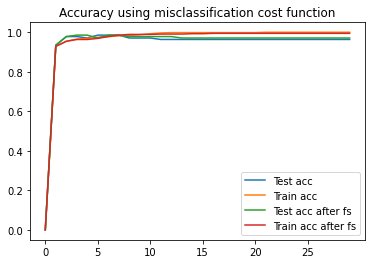

largest test ccuracy when max_depth = 5, the accuracy is 98.5

largest test accuracy (feature selection) when max_depth = 3, the accuracy is 98.5



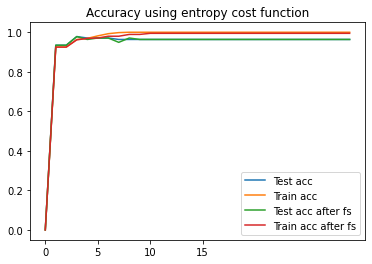

largest test accuracy when max_depth = 3, the accuracy is 97.8

largest test accuracy (feature selection) when max_depth = 3, the accuracy is 97.8



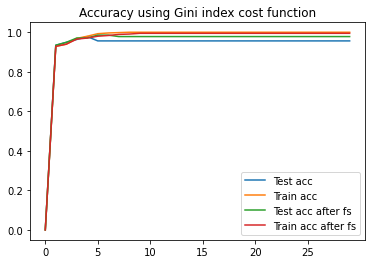

largest test accuracy when max_depth = 4, the accuracy is 97.8

largest test accuracy (feature selection) when max_depth = 5, the accuracy is 98.5



In [7]:


misclassification_test_accs = [0]
misclassification_train_accs = [0]
misclassification_test_accs_fs = [0]
misclassification_train_accs_fs = [0]
depth = range(1, 30)
for i in depth:
  tree = DecisionTree(max_depth=i)
  model = tree.fit(breast_x_train, breast_y_train)
  probs_test = model.predict(breast_x_test)
  probs_train = model.predict(breast_x_train)
  y_pred_test = np.argmax(probs_test,1)
  y_pred_train = np.argmax(probs_train, 1)
  test_accuracy = evaluate_acc(breast_y_test, y_pred_test)
  train_accuracy = evaluate_acc(breast_y_train, y_pred_train)
  misclassification_test_accs.append(test_accuracy)
  misclassification_train_accs.append(train_accuracy)

  tree_fs = DecisionTree(max_depth=i)
  model = tree_fs.fit(breast_x_train_fs, breast_y_train)
  probs_test_fs = model.predict(breast_x_test_fs)
  probs_train_fs = model.predict(breast_x_train_fs)
  y_pred_test_fs = np.argmax(probs_test_fs,1)
  y_pred_train_fs = np.argmax(probs_train_fs, 1)
  test_accuracy = evaluate_acc(breast_y_test, y_pred_test_fs)
  train_accuracy = evaluate_acc(breast_y_train, y_pred_train_fs)
  misclassification_test_accs_fs.append(test_accuracy)
  misclassification_train_accs_fs.append(train_accuracy)

plt.xticks(range(0,30,5))
plt.title("Accuracy using misclassification cost function")

plt.plot(misclassification_test_accs, '-', label="Test acc")
plt.plot(misclassification_train_accs,'-', label="Train acc")
plt.plot(misclassification_test_accs_fs, '-', label="Test acc after fs")
plt.plot(misclassification_train_accs_fs,'-', label="Train acc after fs")
plt.legend()
plt.show()
print(f"largest test ccuracy when max_depth = {misclassification_test_accs.index(max(misclassification_test_accs))}, the accuracy is {max(misclassification_test_accs)*100:.1f}\n")
print(f"largest test accuracy (feature selection) when max_depth = {misclassification_test_accs_fs.index(max(misclassification_test_accs_fs))}, the accuracy is {max(misclassification_test_accs_fs)*100:.1f}\n")

entropy_test_accs = [0]
entropy_train_accs = [0]
entropy_test_accs_fs = [0]
entropy_train_accs_fs = [0]
for i in depth:
  tree = DecisionTree(max_depth=i, cost_fn=cost_entropy)
  model = tree.fit(breast_x_train, breast_y_train)
  probs_test = model.predict(breast_x_test)
  probs_train = model.predict(breast_x_train)
  y_pred_test = np.argmax(probs_test,1)
  y_pred_train = np.argmax(probs_train, 1)
  test_accuracy = np.sum(y_pred_test == breast_y_test)/breast_y_test.shape[0]
  train_accuracy = np.sum(y_pred_train == breast_y_train)/breast_y_train.shape[0]
  entropy_test_accs.append(test_accuracy)
  entropy_train_accs.append(train_accuracy)

  tree_fs = DecisionTree(max_depth=i, cost_fn=cost_entropy)
  model = tree_fs.fit(breast_x_train_fs, breast_y_train)
  probs_test_fs = model.predict(breast_x_test_fs)
  probs_train_fs = model.predict(breast_x_train_fs)
  y_pred_test_fs = np.argmax(probs_test_fs,1)
  y_pred_train_fs = np.argmax(probs_train_fs, 1)
  test_accuracy = evaluate_acc(breast_y_test, y_pred_test_fs)
  train_accuracy = evaluate_acc(breast_y_train, y_pred_train_fs)
  entropy_test_accs_fs.append(test_accuracy)
  entropy_train_accs_fs.append(train_accuracy)

plt.xticks(range(0,20,5))
plt.title("Accuracy using entropy cost function")
plt.plot(entropy_test_accs, '-', label="Test acc")
plt.plot(entropy_train_accs,'-', label="Train acc")
plt.plot(entropy_test_accs_fs, '-', label="Test acc after fs")
plt.plot(entropy_train_accs_fs,'-', label="Train acc after fs")
plt.legend()
plt.show()
print(f"largest test accuracy when max_depth = {entropy_test_accs.index(max(entropy_test_accs))}, the accuracy is {max(entropy_test_accs)*100:.1f}\n")
print(f"largest test accuracy (feature selection) when max_depth = {entropy_test_accs_fs.index(max(entropy_test_accs_fs))}, the accuracy is {max(entropy_test_accs_fs)*100:.1f}\n")

gini_test_accs = [0]
gini_train_accs = [0]
gini_test_accs_fs = [0]
gini_train_accs_fs = [0]
for i in depth:
  tree = DecisionTree(max_depth=i, cost_fn=cost_gini_index)
  model = tree.fit(breast_x_train, breast_y_train)
  probs_test = model.predict(breast_x_test)
  probs_train = model.predict(breast_x_train)
  y_pred_test = np.argmax(probs_test,1)
  y_pred_train = np.argmax(probs_train, 1)
  test_accuracy = np.sum(y_pred_test == breast_y_test)/breast_y_test.shape[0]
  train_accuracy = np.sum(y_pred_train == breast_y_train)/breast_y_train.shape[0]
  gini_test_accs.append(test_accuracy)
  gini_train_accs.append(train_accuracy)

  tree_fs = DecisionTree(max_depth=i, cost_fn=cost_gini_index)
  model = tree_fs.fit(breast_x_train_fs, breast_y_train)
  probs_test_fs = model.predict(breast_x_test_fs)
  probs_train_fs = model.predict(breast_x_train_fs)
  y_pred_test_fs = np.argmax(probs_test_fs,1)
  y_pred_train_fs = np.argmax(probs_train_fs, 1)
  test_accuracy = evaluate_acc(breast_y_test, y_pred_test_fs)
  train_accuracy = evaluate_acc(breast_y_train, y_pred_train_fs)
  gini_test_accs_fs.append(test_accuracy)
  gini_train_accs_fs.append(train_accuracy)

plt.xticks(range(0,30,5))
plt.title("Accuracy using Gini index cost function")
plt.plot(gini_test_accs, '-', label="Test acc")
plt.plot(gini_train_accs,'-', label="Train acc")
plt.plot(gini_test_accs_fs, '-', label="Test acc after fs")
plt.plot(gini_train_accs_fs,'-', label="Train acc after fs")
plt.legend()
plt.show()
print(f"largest test accuracy when max_depth = {gini_test_accs.index(max(gini_test_accs))}, the accuracy is {max(gini_test_accs)*100:.1f}\n")
print(f"largest test accuracy (feature selection) when max_depth = {gini_test_accs_fs.index(max(gini_test_accs_fs))}, the accuracy is {max(gini_test_accs_fs)*100:.1f}\n")
#visualization
# '''
# correct = breast_y_test == y_pred
# incorrect = np.logical_not(correct)
# plt.scatter(breast_x_train[:,0], breast_x_train[:,1], c=breast_y_train, marker='o', alpha=.2, label='train')
# plt.scatter(breast_x_test[correct,0], breast_x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
# plt.scatter(breast_x_test[incorrect,0], breast_x_test[incorrect,1], marker='x', c=breast_y_test[incorrect], label='misclassified')
# plt.legend()
# plt.show()
# '''
# print(probs_test[10:100])


#Hepatitis Dataset Experiments

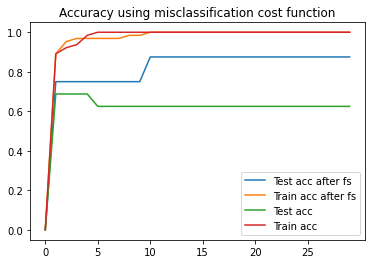

largest test ccuracy when max_depth = 1, the accuracy is 68.8

largest test accuracy (feature selection) when max_depth = 10, the accuracy is 87.5



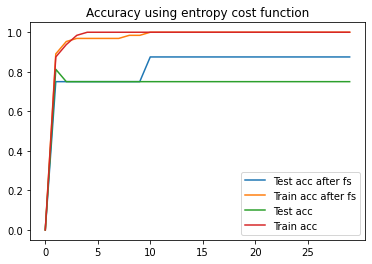

largest test accuracy when max_depth = 1, the accuracy is 81.2

largest test accuracy (feature selection) when max_depth = 10, the accuracy is 87.5



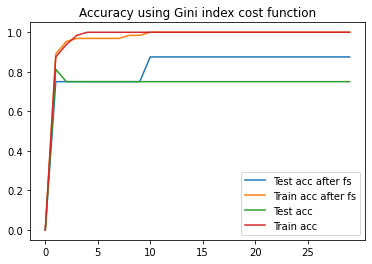

largest test accuracy when max_depth = 1, the accuracy is 81.2

largest test accuracy (feature selection) when max_depth = 10, the accuracy is 87.5



In [8]:

misclassification_test_accs = [0]
misclassification_train_accs = [0]
misclassification_test_accs_fs = [0]
misclassification_train_accs_fs = [0]
depth = range(1, 30)

for i in depth:
  tree = DecisionTree(max_depth=i)
  model = tree.fit(hepatitis_x_train, hepatitis_y_train)
  probs_test = model.predict(hepatitis_x_test)
  probs_train = model.predict(hepatitis_x_train)
  y_pred_test = np.argmax(probs_test,1)
  y_pred_train = np.argmax(probs_train, 1)
  test_accuracy = evaluate_acc(hepatitis_y_test, y_pred_test)
  train_accuracy = evaluate_acc(hepatitis_y_train, y_pred_train)
  misclassification_test_accs.append(test_accuracy)
  misclassification_train_accs.append(train_accuracy)

  tree_fs = DecisionTree(max_depth=i)
  model = tree_fs.fit(hepatitis_x_train_fs, hepatitis_y_train)
  probs_test_fs = model.predict(hepatitis_x_test_fs)
  probs_train_fs = model.predict(hepatitis_x_train_fs)
  y_pred_test_fs = np.argmax(probs_test_fs,1)
  y_pred_train_fs = np.argmax(probs_train_fs, 1)
  test_accuracy = evaluate_acc(hepatitis_y_test, y_pred_test_fs)
  train_accuracy = evaluate_acc(hepatitis_y_train, y_pred_train_fs)
  misclassification_test_accs_fs.append(test_accuracy)
  misclassification_train_accs_fs.append(train_accuracy)

plt.xticks(range(0,30,5))
plt.title("Accuracy using misclassification cost function")
plt.plot(misclassification_test_accs_fs, label="Test acc after fs")
plt.plot(misclassification_train_accs_fs,label="Train acc after fs")
plt.plot(misclassification_test_accs, label="Test acc")
plt.plot(misclassification_train_accs, label="Train acc")
plt.legend()
plt.show()
print(f"largest test ccuracy when max_depth = {misclassification_test_accs.index(max(misclassification_test_accs))}, the accuracy is {max(misclassification_test_accs)*100:.1f}\n")
print(f"largest test accuracy (feature selection) when max_depth = {misclassification_test_accs_fs.index(max(misclassification_test_accs_fs))}, the accuracy is {max(misclassification_test_accs_fs)*100:.1f}\n")

entropy_test_accs = [0]
entropy_train_accs = [0]
entropy_test_accs_fs = [0]
entropy_train_accs_fs = [0]
for i in depth:
  tree = DecisionTree(max_depth=i, cost_fn=cost_entropy)
  model = tree.fit(hepatitis_x_train, hepatitis_y_train)
  probs_test = model.predict(hepatitis_x_test)
  probs_train = model.predict(hepatitis_x_train)
  y_pred_test = np.argmax(probs_test,1)
  y_pred_train = np.argmax(probs_train, 1)
  test_accuracy = evaluate_acc(hepatitis_y_test, y_pred_test)
  train_accuracy = evaluate_acc(hepatitis_y_train, y_pred_train)
  entropy_test_accs.append(test_accuracy)
  entropy_train_accs.append(train_accuracy)

  tree_fs = DecisionTree(max_depth=i)
  model = tree_fs.fit(hepatitis_x_train_fs, hepatitis_y_train)
  probs_test_fs = model.predict(hepatitis_x_test_fs)
  probs_train_fs = model.predict(hepatitis_x_train_fs)
  y_pred_test_fs = np.argmax(probs_test_fs,1)
  y_pred_train_fs = np.argmax(probs_train_fs, 1)
  test_accuracy = evaluate_acc(hepatitis_y_test, y_pred_test_fs)
  train_accuracy = evaluate_acc(hepatitis_y_train, y_pred_train_fs)
  entropy_test_accs_fs.append(test_accuracy)
  entropy_train_accs_fs.append(train_accuracy)

plt.xticks(range(0,30,5))
plt.title("Accuracy using entropy cost function")
plt.plot(entropy_test_accs_fs, label="Test acc after fs")
plt.plot(entropy_train_accs_fs,label="Train acc after fs")
plt.plot(entropy_test_accs, label="Test acc")
plt.plot(entropy_train_accs, label="Train acc")
plt.legend()
plt.show()
print(f"largest test accuracy when max_depth = {entropy_test_accs.index(max(entropy_test_accs))}, the accuracy is {max(entropy_test_accs)*100:.1f}\n")
print(f"largest test accuracy (feature selection) when max_depth = {entropy_test_accs_fs.index(max(entropy_test_accs_fs))}, the accuracy is {max(entropy_test_accs_fs)*100:.1f}\n")

gini_test_accs = [0]
gini_train_accs = [0]
gini_test_accs_fs = [0]
gini_train_accs_fs = [0]
for i in depth:
  tree = DecisionTree(max_depth=i, cost_fn=cost_gini_index)
  model = tree.fit(hepatitis_x_train, hepatitis_y_train)
  probs_test = model.predict(hepatitis_x_test)
  probs_train = model.predict(hepatitis_x_train)
  y_pred_test = np.argmax(probs_test,1)
  y_pred_train = np.argmax(probs_train, 1)
  test_accuracy = evaluate_acc(hepatitis_y_test, y_pred_test)
  train_accuracy = evaluate_acc(hepatitis_y_train, y_pred_train)
  gini_test_accs.append(test_accuracy)
  gini_train_accs.append(train_accuracy)

  tree_fs = DecisionTree(max_depth=i)
  model = tree_fs.fit(hepatitis_x_train_fs, hepatitis_y_train)
  probs_test_fs = model.predict(hepatitis_x_test_fs)
  probs_train_fs = model.predict(hepatitis_x_train_fs)
  y_pred_test_fs = np.argmax(probs_test_fs,1)
  y_pred_train_fs = np.argmax(probs_train_fs, 1)
  test_accuracy = evaluate_acc(hepatitis_y_test, y_pred_test_fs)
  train_accuracy = evaluate_acc(hepatitis_y_train, y_pred_train_fs)
  gini_test_accs_fs.append(test_accuracy)
  gini_train_accs_fs.append(train_accuracy)


plt.xticks(range(0,30,5))
plt.title("Accuracy using Gini index cost function")
plt.plot(gini_test_accs_fs, label="Test acc after fs")
plt.plot(gini_train_accs_fs,label="Train acc after fs")
plt.plot(gini_test_accs, '-', label="Test acc")
plt.plot(gini_train_accs,'-', label="Train acc")
plt.legend()
plt.show()
print(f"largest test accuracy when max_depth = {gini_test_accs.index(max(gini_test_accs))}, the accuracy is {max(gini_test_accs)*100:.1f}\n")
print(f"largest test accuracy (feature selection) when max_depth = {gini_test_accs_fs.index(max(gini_test_accs_fs))}, the accuracy is {max(gini_test_accs_fs)*100:.1f}\n")
#visualization

# '''
# correct = hepatitis_y_test == y_pred
# incorrect = np.logical_not(correct)
# plt.scatter(hepatitis_x_train[:,0], hepatitis_x_train[:,1], c=hepatitis_y_train, marker='o', alpha=.2, label='train')
# plt.scatter(hepatitis_x_test[correct,0], hepatitis_x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
# plt.scatter(hepatitis_x_test[incorrect,0],hepatitis_x_test[incorrect,1], marker='x', c=hepatitis_y_test[incorrect], label='misclassified')
# plt.legend()
# plt.show()
# '''

## Decision Boundaries for Breast
To draw the decision boundary we classify all the points on a 2D grid. The `meshgrid` function creates all the points on the grid by taking discretizations of horizontal and vertical axes.

using misclassificaiton to draw boundaries


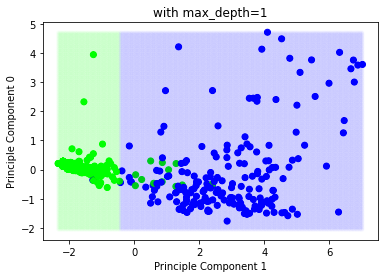

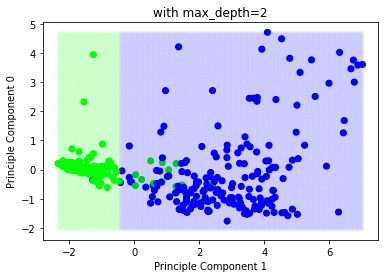

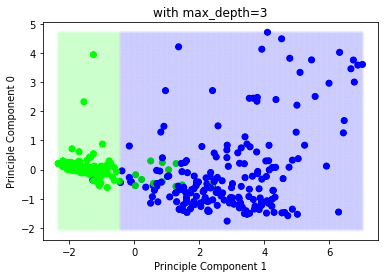

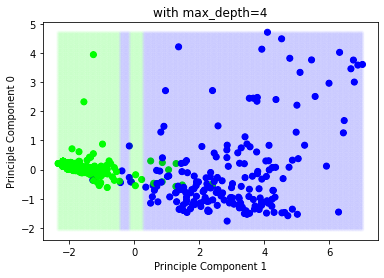

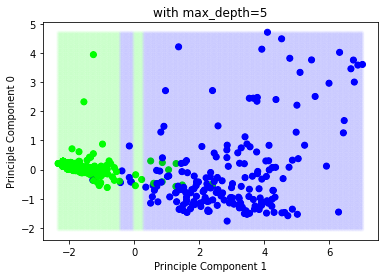

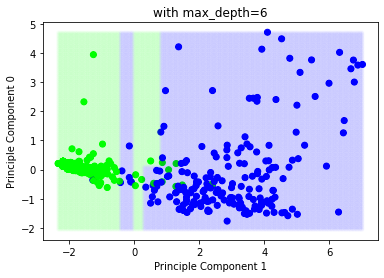

********************************************************************************
using gini to draw boundaries


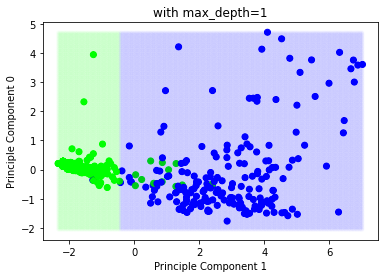

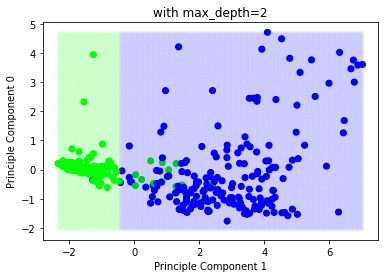

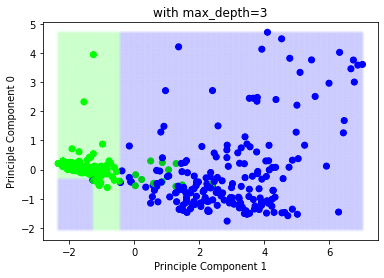

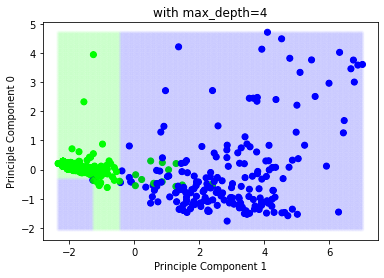

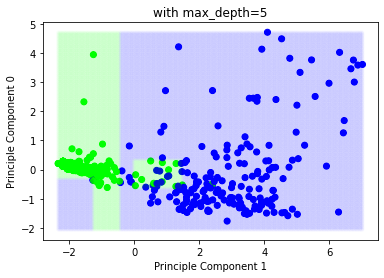

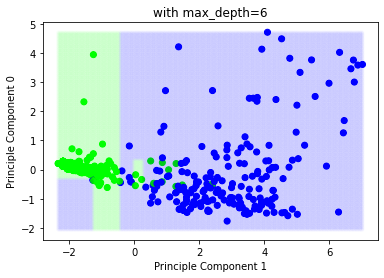

********************************************************************************
using entropy to draw boundaries


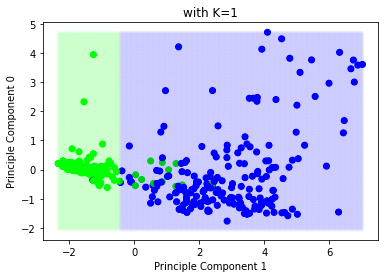

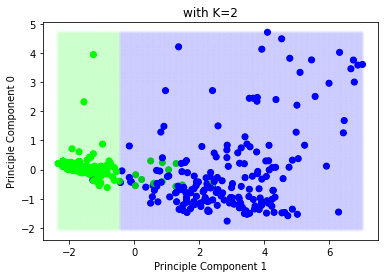

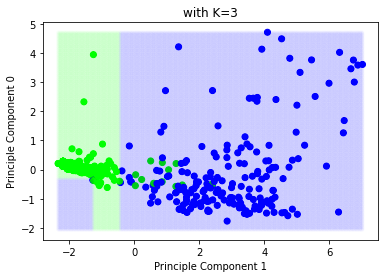

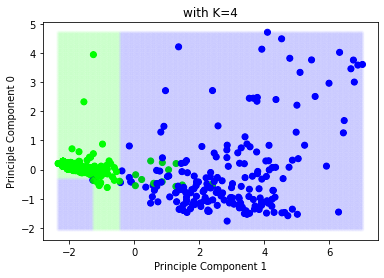

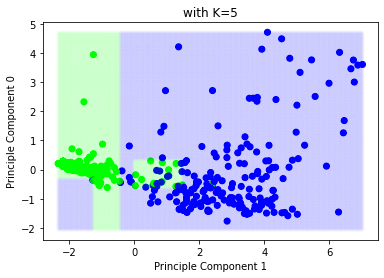

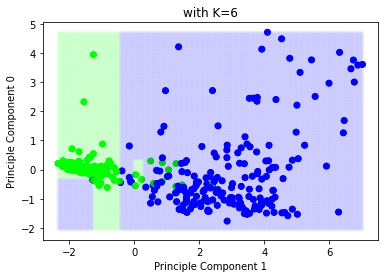

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

std_breast_x = StandardScaler().fit_transform(breast_x)

b_pca=PCA(n_components=2,copy=True)
b_principal_components = b_pca.fit_transform(std_breast_x)

std_breast_x_train = b_principal_components[breast_inds[:breast_partition]]

#we can make the grid finer by increasing the number of samples from 200 to higher value
x0v = np.linspace(np.min(b_principal_components[:,0]), np.max(b_principal_components[:,0]), 250)
x1v = np.linspace(np.min(b_principal_components[:,1]), np.max(b_principal_components[:,1]), 250)
#to features values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T
C = int(np.max(breast_y))+1

print("using misclassificaiton to draw boundaries")
for i in range(1,7):
  tree = DecisionTree(max_depth=i)
  y_train_prob = np.zeros((breast_y_train.shape[0], C))
  y_train_prob[np.arange(breast_y_train.shape[0]), breast_y_train] = 1
  

  #to get class probability of all the points in the 2D grid
  y_prob_all = tree.fit(std_breast_x_train, breast_y_train).predict(x_all)

  y_pred_all = np.zeros_like(y_prob_all)
  y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

  plt.scatter(std_breast_x_train[:,0], std_breast_x_train[:,1], c=y_train_prob, marker='o', alpha=1)
  plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=0.01)
  plt.title(f"with max_depth={i}")
  plt.ylabel('Principle Component 0')
  plt.xlabel('Principle Component 1')
  plt.show()

################################
print("********************************************************************************")
print("using gini to draw boundaries")
for i in range(1,7):
  tree = DecisionTree(max_depth=i,cost_fn=cost_gini_index)
  y_train_prob = np.zeros((breast_y_train.shape[0], C))
  y_train_prob[np.arange(breast_y_train.shape[0]), breast_y_train] = 1
  
  #to get class probability of all the points in the 2D grid
  y_prob_all = tree.fit(std_breast_x_train, breast_y_train).predict(x_all)

  y_pred_all = np.zeros_like(y_prob_all)
  y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

  plt.scatter(std_breast_x_train[:,0], std_breast_x_train[:,1], c=y_train_prob, marker='o', alpha=1)
  plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=0.01)
  plt.title(f"with max_depth={i}")
  plt.ylabel('Principle Component 0')
  plt.xlabel('Principle Component 1')
  plt.show()

################################
print("********************************************************************************")
print("using entropy to draw boundaries")
for i in range(1,7):
  tree = DecisionTree(max_depth=i,cost_fn=cost_entropy)
  y_train_prob = np.zeros((breast_y_train.shape[0], C))
  y_train_prob[np.arange(breast_y_train.shape[0]), breast_y_train] = 1
  
  #to get class probability of all the points in the 2D grid
  y_prob_all = tree.fit(std_breast_x_train, breast_y_train).predict(x_all)

  y_pred_all = np.zeros_like(y_prob_all)
  y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

  plt.scatter(std_breast_x_train[:,0], std_breast_x_train[:,1], c=y_train_prob, marker='o', alpha=1)
  plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=0.01)
  plt.title(f"with K={i}")
  plt.ylabel('Principle Component 0')
  plt.xlabel('Principle Component 1')
  plt.show()

## Decision Boundaries for Hepatitis

To draw the decision boundary we classify all the points on a 2D grid. The `meshgrid` function creates all the points on the grid by taking discretizations of horizontal and vertical axes.

using misclassfication to draw boundaries


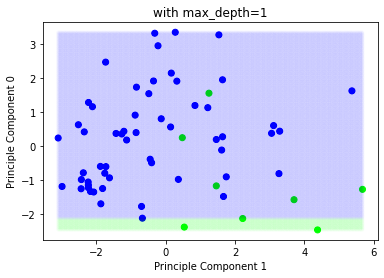

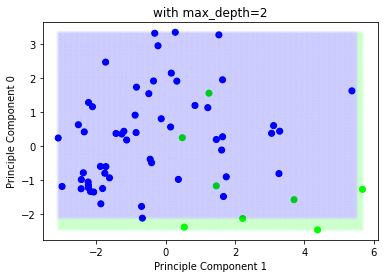

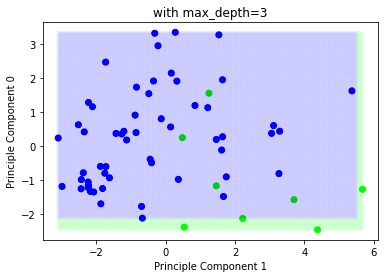

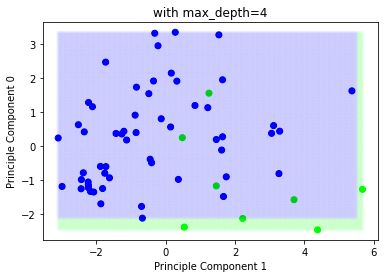

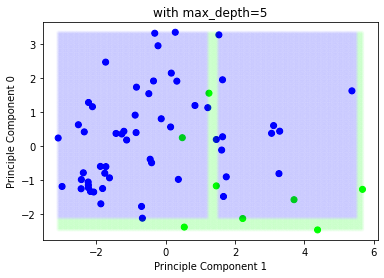

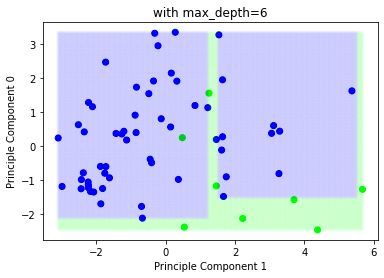

********************************************************************************
using entropy to draw boundaries


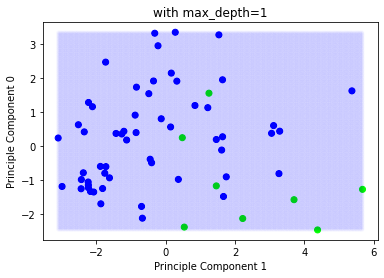

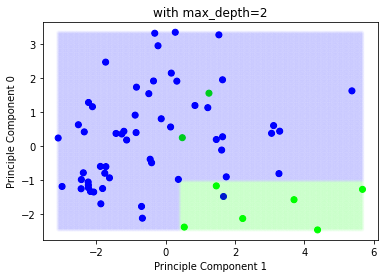

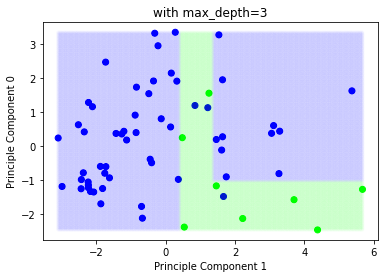

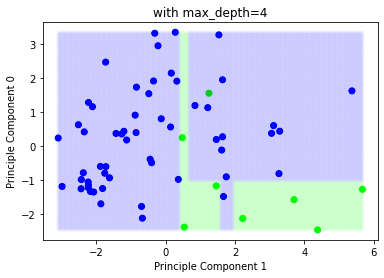

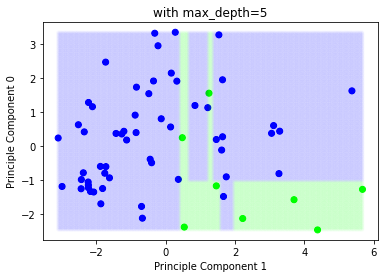

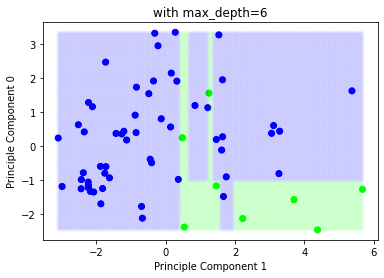

********************************************************************************
using gini to draw boundaries


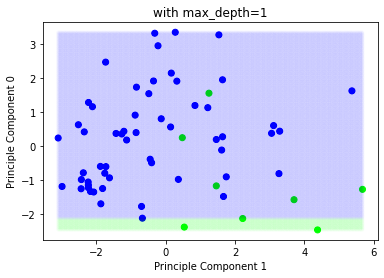

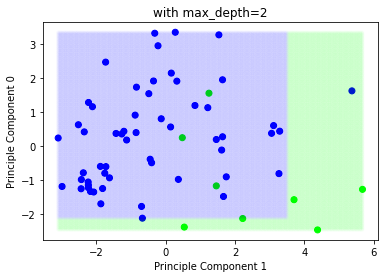

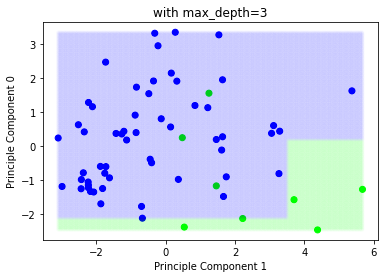

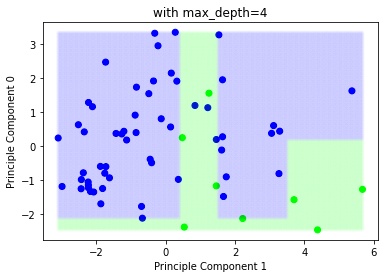

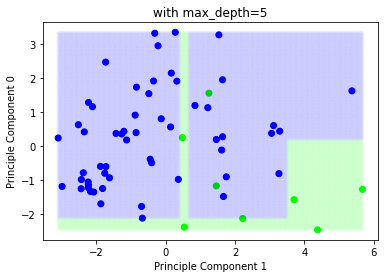

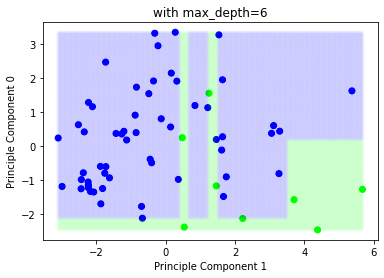

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

std_hepatitis_x = StandardScaler().fit_transform(hepatitis_x)
h_pca=PCA(n_components=2,copy=True)
h_principal_components = h_pca.fit_transform(std_hepatitis_x)
std_hepatitis_x_train = h_principal_components[hepatitis_inds[:hepatitis_partition]]

#we can make the grid finer by increasing the number of samples from 200 to higher value
x0v = np.linspace(np.min(h_principal_components[:,0]), np.max(h_principal_components[:,0]), 250)
x1v = np.linspace(np.min(h_principal_components[:,1]), np.max(h_principal_components[:,1]), 250)
#to features values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T
C = int(np.max(hepatitis_y))+1

print("using misclassfication to draw boundaries")
for i in range(1,7):
  tree = DecisionTree(max_depth=i)

  y_train_prob = np.zeros((hepatitis_y_train.shape[0], C))
  y_train_prob[np.arange(hepatitis_y_train.shape[0]), hepatitis_y_train] = 1
  

  #to get class probability of all the points in the 2D grid
  y_prob_all = tree.fit(std_hepatitis_x_train, hepatitis_y_train).predict(x_all)

  y_pred_all = np.zeros_like(y_prob_all)
  y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

  plt.scatter(std_hepatitis_x_train[:,0], std_hepatitis_x_train[:,1], c=y_train_prob, marker='o', alpha=1)
  plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=0.01)
  plt.title(f"with max_depth={i}")
  plt.ylabel('Principle Component 0')
  plt.xlabel('Principle Component 1')
  plt.show()

################################
print("********************************************************************************")
print("using entropy to draw boundaries")
for i in range(1,7):
  tree = DecisionTree(max_depth=i,cost_fn=cost_entropy)

  y_train_prob = np.zeros((hepatitis_y_train.shape[0], C))
  y_train_prob[np.arange(hepatitis_y_train.shape[0]), hepatitis_y_train] = 1
  #to get class probability of all the points in the 2D grid
  y_prob_all = tree.fit(std_hepatitis_x_train, hepatitis_y_train).predict(x_all)

  y_pred_all = np.zeros_like(y_prob_all)
  y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

  plt.scatter(std_hepatitis_x_train[:,0], std_hepatitis_x_train[:,1], c=y_train_prob, marker='o', alpha=1)
  plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=0.01)
  plt.title(f"with max_depth={i}")
  plt.ylabel('Principle Component 0')
  plt.xlabel('Principle Component 1')
  plt.show()
################################
print("********************************************************************************")
print("using gini to draw boundaries")
for i in range(1,7):
  tree = DecisionTree(max_depth=i,cost_fn=cost_gini_index)

  y_train_prob = np.zeros((hepatitis_y_train.shape[0], C))
  y_train_prob[np.arange(hepatitis_y_train.shape[0]), hepatitis_y_train] = 1
  #to get class probability of all the points in the 2D grid
  y_prob_all = tree.fit(std_hepatitis_x_train, hepatitis_y_train).predict(x_all)

  y_pred_all = np.zeros_like(y_prob_all)
  y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

  plt.scatter(std_hepatitis_x_train[:,0], std_hepatitis_x_train[:,1], c=y_train_prob, marker='o', alpha=1)
  plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=0.01)
  plt.title(f"with max_depth={i}")
  plt.ylabel('Principle Component 0')
  plt.xlabel('Principle Component 1')
  plt.show()